# Figures and Tables for the reporting delay model

In [8]:
library(here)
source(here("setup.R"))


## Parameters

In [2]:
theta_showcase <- read_csv(here("data/results/4_showcase_model/thetas.csv")) %>%
    rename("\\rho" = 2)
theta_showcase

variances <- theta_showcase %>%
    mutate(across(where(is.numeric), ~ exp(.x)))
variances

sds <- variances %>%
    mutate(across(where(is.numeric), ~ sqrt(.x)))
sds

# use scientific notation
sds %>%
    rename_with(function(col) str_glue("$\\hat\\sigma_{col}$"), where(is.numeric)) %>%
    kable(format = "latex", format.args = list(scipen = 2, digits = 2), booktabs = T, escape = F) %>%
    cat(., file = here("tables/showcase-parameters.tex"))


method,\rho,W,q,M
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
manual,-13.815511,-4.605170,-1.3862944,-9.210340
initial,-8.510855,-7.691463,0.5779217,-4.445763
MLE,-8.510845,-7.691457,0.5795065,-4.445750


method,\rho,W,q,M
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
manual,0.0000010000,0.0100000000,0.250000,0.00010000
initial,0.0002012717,0.0004567096,1.782330,0.01172815
MLE,0.0002012736,0.0004567122,1.785157,0.01172830


method,\rho,W,q,M
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
manual,0.00100000,0.10000000,0.500000,0.0100000
initial,0.01418703,0.02137076,1.335039,0.1082966
MLE,0.01418709,0.02137083,1.336098,0.1082973


## Predictions

In [9]:
dim(predictions)


[1]  25 240   8

pdf 
  2

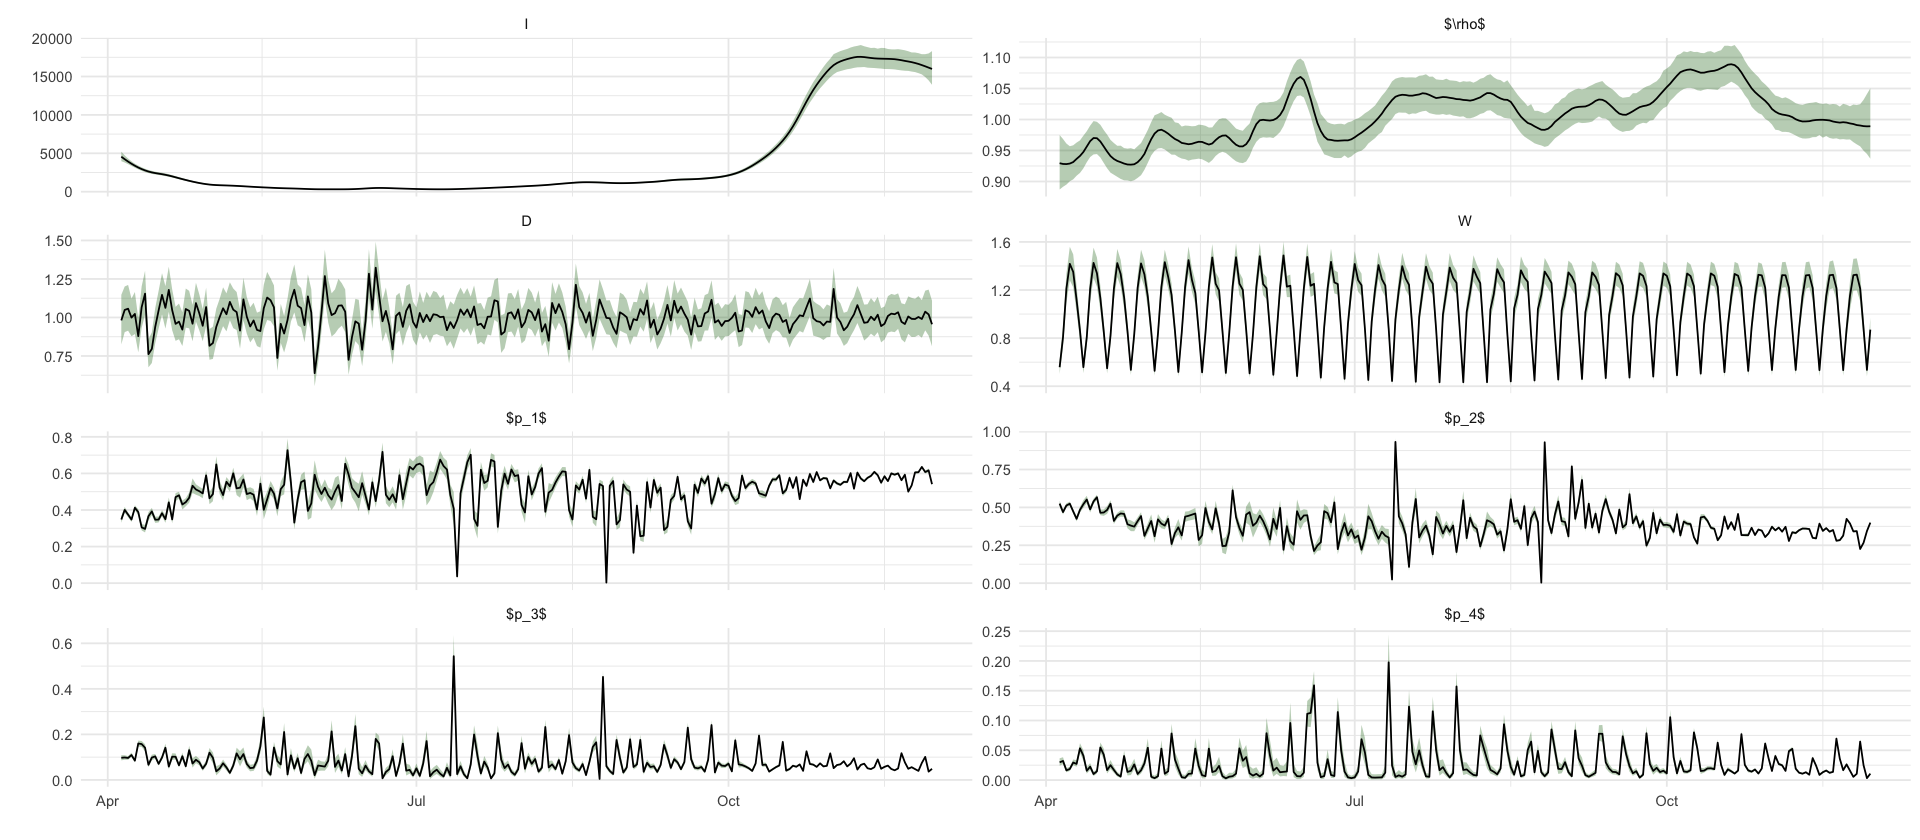

In [75]:
default_probs <- c(0.01, 0.025, 0.05 * 1:19, 0.975, 0.99)
read_predictions <- function(fname, dates, variables, probs = default_probs) {
    np <- import("numpy")
    predictions <- np$load(fname)

    dimnames(predictions) <- list(
        "type" = c("mean", "sd", probs),
        "date" = as.character(dates),
        "variable" = variables
    )

    df_predictions <- melt(predictions) %>%
        mutate(date = ymd(date)) %>%
        pivot_wider(id_cols = c(date, variable), names_from = "type", values_from = "value")
    df_predictions
}
df_showcase <- read_predictions(
    here("data/results/4_showcase_model/predictions.npy"),
    seq(ymd("2020-04-05"), ymd("2020-11-30"), by = "1 day"),
    c("I", "$\\rho$", "D", "W", "$p_1$", "$p_2$", "$p_3$", "$p_4$")
)
df_showcase %>%
    ggplot(aes(date, mean)) +
    geom_ribbon(aes(date, ymin = `0.025`, ymax = `0.975`), fill = "darkgreen", alpha = .3) +
    geom_line() +
    facet_wrap(~variable, scales = "free_y", nrow = 4) +
    labs(x = "", y = "")
ggsave_tikz(here("tikz/showcase_prediction_intervals.tex"), height = 2 * default_height)


In [30]:
df_showcase


type,date,variable,value
<fct>,<date>,<fct>,<dbl>
mean,2020-04-05,I,4557.4379
sd,2020-04-05,I,336.6837
0.01,2020-04-05,I,3881.7662
0.025,2020-04-05,I,3975.3464
0.05,2020-04-05,I,4025.9759
0.1,2020-04-05,I,4111.7320
0.15,2020-04-05,I,4196.5421
0.2,2020-04-05,I,4258.4199
0.25,2020-04-05,I,4299.5392
